# Predicting when a company will send it's next marketing email

This project aims to predict when a company will send it's next marketing email. The data comes from [MailCharts](https://www.mailcharts.com/).

Predicting when your competitors will send their next marketing blast allows you to get ahead of the game and send your email before they do.

- Sample data: http://share.mailcharts.com/0b141Z3c1M40
- All data: _coming soon_

In [119]:
# Import libraries and dependencies

from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split 

In [159]:
# Import the data

df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(4585, 6)

In [160]:
# Add first set of features we need

df['sent_time'] = pd.to_datetime(df.sent_at)
df['hour'] = df.sent_time.apply(lambda x: x.hour)
df['day'] = df.sent_time.apply(lambda x: x.day)
df['month'] = df.sent_time.apply(lambda x: x.month)
df['year'] = df.sent_time.apply(lambda x: x.year)
df['day_of_week'] = df.sent_time.dt.weekday_name 
df['day_of_week_num'] = df.sent_time.dt.weekday 
df['weekend'] = df.day_of_week.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
df["weeknum"] = df.sent_time.dt.weekofyear
df["am_pm"] = df.sent_time.apply(lambda x: 1 if x.strftime('%p') == "AM" else 0)

In [161]:
# Gather when the previous email was sent
## TODO: HOW CAN WE MAKE THIS RUN FASTER

df = df.sort_values("sent_at", ascending=False)
results = []
for index, row in df.iterrows():
    company_emails = df[df["company_id"] == row["company_id"]]
    earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
    if len(earlier_emails) > 0:
        results.append(earlier_emails[0])
        continue
    else:
        results.append(None)

# Save the results to our dataframe
df["prev_email"] = results

In [162]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["delta_in_seconds"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

In [163]:
# QA that we only have 1 time_delta with a value of 0

df[df["delta_in_seconds"] == 0]["company_name"].value_counts()

Ace & Tate             1
10DollarMall           1
AllModern              1
1000Bulbs.com          1
1-800-Flowers.com      1
Adorama                1
Ace & Everett          1
Allurez                1
A'GACI                 1
Abercrombie & Fitch    1
Name: company_name, dtype: int64

In [164]:
# Add a few more features which will make it easier to read our time deltas

df["delta_in_hours"] = df["delta_in_seconds"] / 60 / 60
df["delta_in_days"] = df["delta_in_seconds"] / 60 / 60 / 24

In [165]:
# Get company dummies. This will help us calculate each prediction at a company level

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

# Merge both dataframes

df = pd.merge(df, dummy_company, right_index=True, left_index=True)

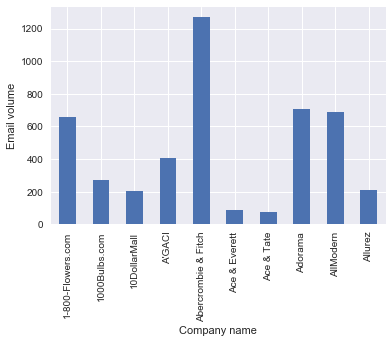

In [166]:
# Visualize  send volume to understand the data a bit better
# Takeaway #1: Email volume varies drastically by company.
# Also, we may have some heavy senders. 1,200+ emails by abercrombie seems extremely high.

email_counts_sum = df.groupby(["company_name"])["delta_in_seconds"].count()
bars = email_counts_sum.plot(kind='bar')
bars.set_ylabel("Email volume")
bars.set_xlabel("Company name")

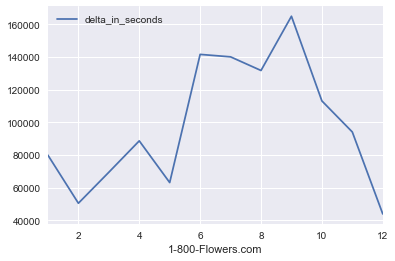

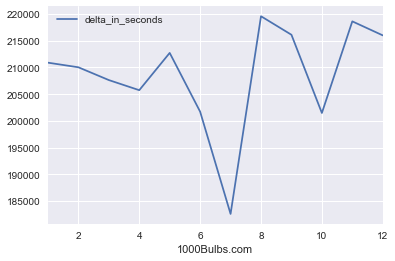

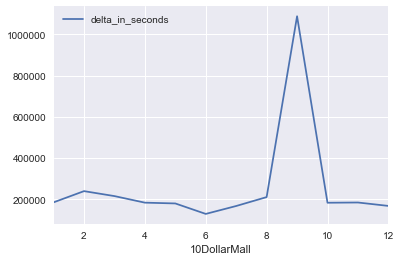

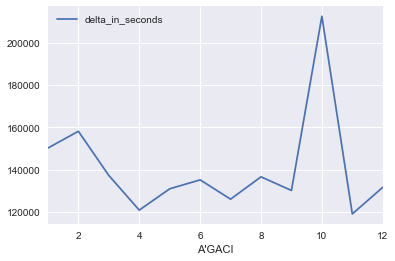

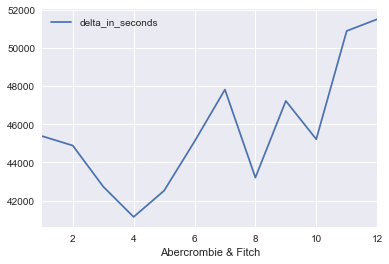

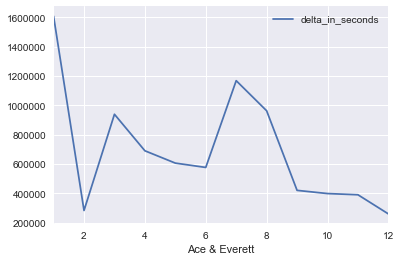

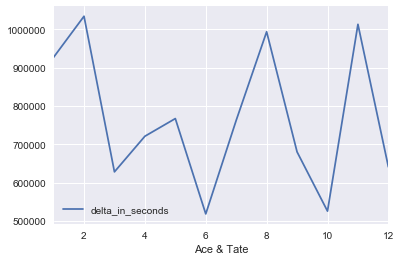

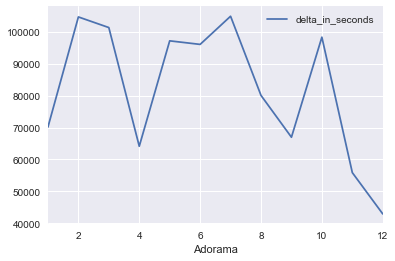

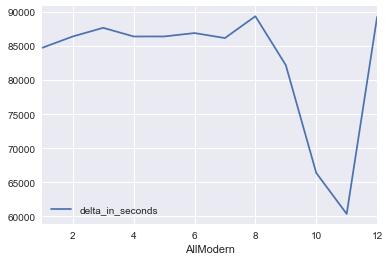

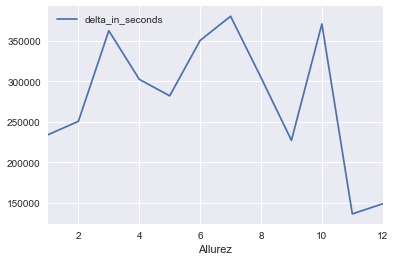

In [167]:
# Let's analyze the sending behavior of these companies
# Takeaway #2: Every company has their own sending behavior!
# Takeaway #3: Seasonality is likely to impact email frequency.
# Note: Spikes == more time in between emails

time_delta_average_by_month = df.groupby(by=['company_name', 'month'])["delta_in_seconds"].mean().reset_index()
c_name = time_delta_average_by_month["company_name"].unique()

for i in c_name:
    company = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].reset_index()
    plot = company.plot(x="month", y="delta_in_seconds")
    plot.set_xlabel(i)


In [168]:
# It's not 100% clear here, but it looks like industry could be a helpful feature to include in our model
# Let's visualize this

df.groupby(["industry_name", "company_name"]).delta_in_seconds.mean().astype(int).reset_index().sort_values("delta_in_seconds")

,industry_name,company_name,delta_in_seconds
6,retail,Abercrombie & Fitch,44965
3,photography,Adorama,80291
0,e-commerce,AllModern,82759
4,retail,1-800-Flowers.com,86788
5,retail,A'GACI,139194
1,lighting,1000Bulbs.com,207690
2,other,Ace & Tate,728605


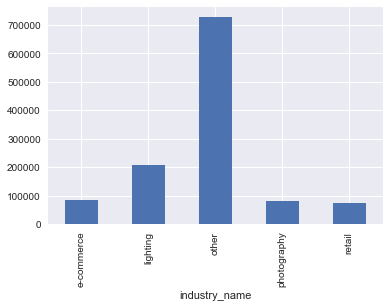

In [169]:
# Visualize the send volume to understand the data a bit better
# Takeaway #4: Consider adding industry as a feature

email_between_time_avg = df.groupby(["industry_name"]).delta_in_seconds.mean()
email_between_time_avg.plot(kind='bar')

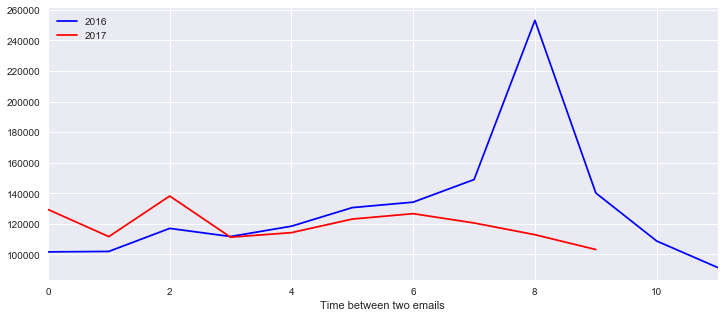

In [189]:
# Let's analyze all of the data by month to see how our 2 years of data compare
# TODO: Make the x-axis start from 1 (January) and not 0

plt.figure(figsize=(12,5))
plt.xlabel('Time between two emails')

df1 = df[df["year"] == 2016].groupby("month").delta_in_seconds.mean().reset_index()
df2 = df[df["year"] == 2017].groupby("month").delta_in_seconds.mean().reset_index()

ax1 = df1.delta_in_seconds.plot(color='blue', label='2016')
ax2 = df2.delta_in_seconds.plot(color='red', label='2017')

plt.legend(h1, l1, loc=2)
plt.show()

# We can see the impact of seasonality

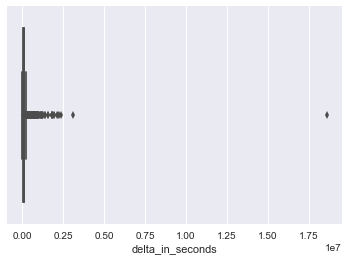

In [190]:
# Next, let's look at the distribution of our email delta

sns.boxplot(x=df["delta_in_seconds"])

# Look at that...! We have some outliers. Let's remove them.

(4585, 30)
(4557, 30)
We removed 28 outliers


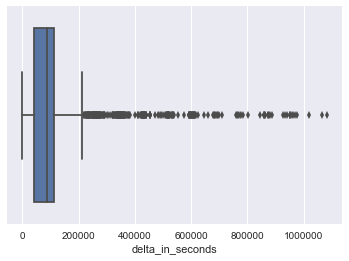

In [191]:
# Remove prev_time_delta outliers

stdev = df.delta_in_seconds.std()
mean = df.delta_in_seconds.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = df[(df.delta_in_seconds >=lower_bound) & (df.delta_in_seconds <= upper_bound)]

print(df.shape)
print(non_outliers.shape)
print("We removed", df.shape[0] - non_outliers.shape[0], "outliers")
sns.boxplot(x=non_outliers["delta_in_seconds"])

In [192]:
# This looks good, let's assign this back to our df variable

df = non_outliers

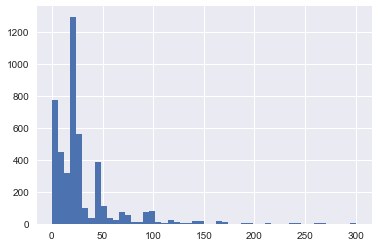

In [197]:
# Let's get a graps of how our data is distributed

df.delta_in_hours.hist(bins = 50)

# Look at that, it's left skewed!

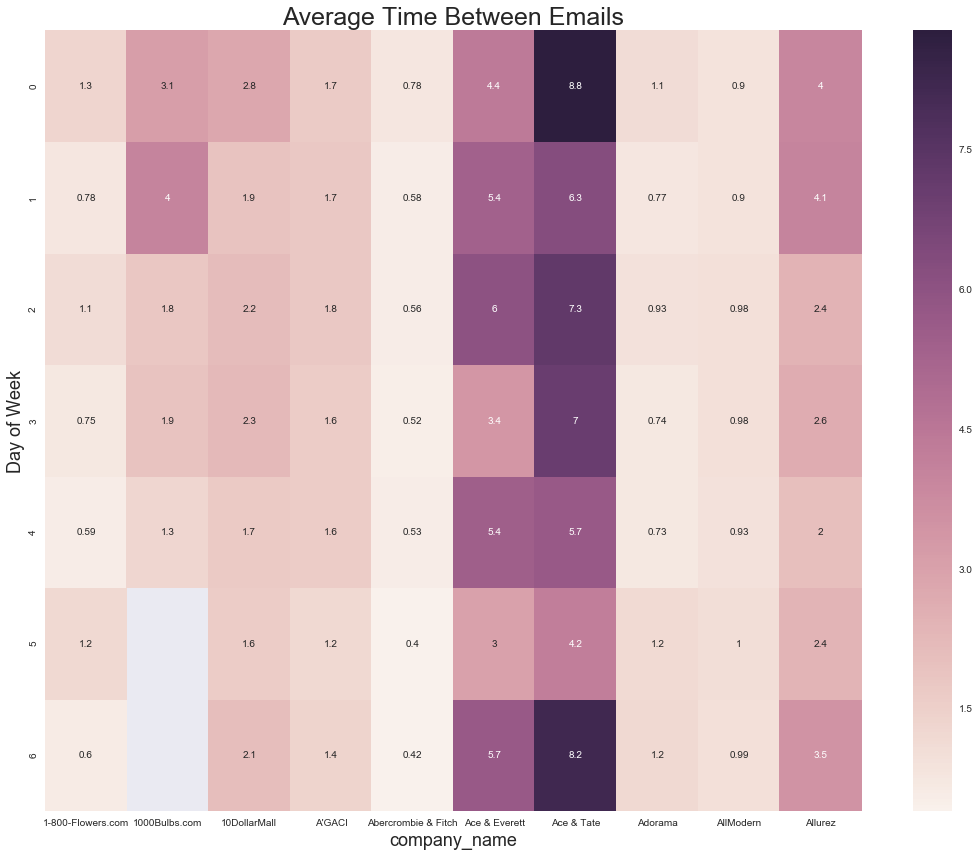

In [235]:
# Let's build a heatmap!

f = plt.figure(1, figsize = (15,12))
# for i,weekend in enumerate([0,1]):
#     pvt = pd.pivot_table(data=df,values='delta_in_days',index='day_of_week', columns='company_name')
#     ax = f.add_subplot(2, 1, i+1)
#     sns.heatmap(pvt, annot=True)
#     plt.title('Average Time Between Emails'.format(weekend),fontsize=25)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.xlabel('company_name',fontsize=18)
#     plt.ylabel('Day of Week',fontsize=18)
#     plt.tight_layout()

pvt = pd.pivot_table(data=df,values='delta_in_days',index='day_of_week_num', columns='company_name')
sns.heatmap(pvt, annot=True)
plt.title('Average Time Between Emails'.format(weekend),fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('company_name',fontsize=18)
plt.ylabel('Day of Week',fontsize=18)
plt.tight_layout()

plt.show()

In [237]:
# Let's try creating a new feature for retail / not retail

df['retail_ecommerce']=(df.industry_name=='retail') ^ (df.industry_name=='e-commerce')

In [243]:
# Let's analyze seasonality

def season_map(month):
    season=''
    if month <=3:
        season='Spring'
    elif month<=6:
        season='Summer'
    elif month<=9:
        season='Fall'
    else: 
        season='Winter'
    return season

df['season']=df.month.apply(lambda x:season_map(x))
df['season_num'] = pd.Categorical(df.season).codes

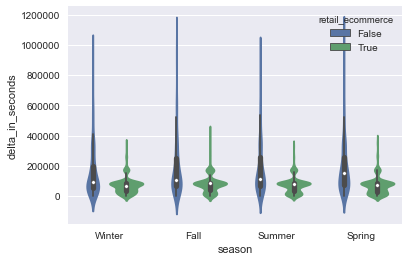

In [242]:
sns.violinplot(x='season', y='delta_in_seconds', data=df, hue='retail_ecommerce' )

## Done with EDA

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

In [252]:
# The modeling begins

target = df.delta_in_seconds
features = df[['season_num', 'weekend', 'retail_ecommerce']]
X_train, X_test, y_train, y_test = train_test_split(features, target)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3417, 3)
(3417,)
(1140, 3)
(1140,)


In [253]:
# Initialize our fit our model

lg = LinearRegression()
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [255]:
y_pred = lg.predict(X_test)
lg.score(X_test, y_test)

0.16026743508313168

In [256]:
# Homework
## Make the timestamp function WAY faster
## Try and get a liner regression score above 16
## Look into decision tree regressor (visualize it to see how the features are splitting your results)